In [64]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import normalize
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import add  # for Residual connections
from tensorflow.keras.regularizers import l2

In [73]:
def custom_unet(input_size=(256, 256, 3), num_classes=1, dropout_rate=0.5, batch_norm=True):
    inputs = Input(input_size)

    def conv_block(input_tensor, num_filters, kernel_size=3, batch_norm=batch_norm):
        # Convolutional layer
        x = Conv2D(num_filters, (kernel_size, kernel_size), padding='same')(input_tensor)
        if batch_norm:
            # Batch normalization layer
            x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # Second convolutional layer
        x = Conv2D(num_filters, (kernel_size, kernel_size), padding='same')(x)
        if batch_norm:
            x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    def encoder_block(input_tensor, num_filters):
        # Conv block
        x = conv_block(input_tensor, num_filters)
        # Pooling layer
        p = MaxPooling2D((2, 2))(x)
        return x, p

    def decoder_block(input_tensor, concat_tensor, num_filters):
        # Upsampling layer
        x = UpSampling2D((2, 2))(input_tensor)
        # Concatenation with skip connection
        x = concatenate([x, concat_tensor])
        # Conv block
        x = conv_block(x, num_filters)
        return x

    # Encoder
    c1, p1 = encoder_block(inputs, 32)
    c2, p2 = encoder_block(p1, 64)
    c3, p3 = encoder_block(p2, 128)
    c4, p4 = encoder_block(p3, 256)

    # Bottleneck
    b = conv_block(p4, 512)

    # Dropout
    b = Dropout(dropout_rate)(b)

    # Decoder
    d1 = decoder_block(b, c4, 256)
    d2 = decoder_block(d1, c3, 128)
    d3 = decoder_block(d2, c2, 64)
    d4 = decoder_block(d3, c1, 32)

    # Output layer
    if num_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(num_classes, (1, 1), activation=activation)(d4)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [74]:
model = custom_unet()

In [75]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  


 conv2d_39 (Conv2D)             (None, 256, 256, 32  896         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 256, 256, 32  128        ['conv2d_39[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_18 (Activation)     (None, 256, 256, 32  0           ['batch_normalization_19[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_40 (Conv2D)             (None, 256, 256, 32  9248        ['activation_18[0][0]']          
          

In [76]:
dummy_input = tf.random.normal([1, 256, 256, 3])
dummy_output = model(dummy_input)
print("Output shape:", dummy_output.shape)

Output shape: (1, 256, 256, 1)


In [77]:
def load_images_and_masks(image_dir, mask_dir, image_size=(256, 256), percentage=50):
    images = []
    masks = []
    image_files = os.listdir(image_dir)
    total_images = len(image_files)
    
    # Calculate how many images to load based on the percentage
    num_images_to_load = int(total_images * (percentage / 100.0))

    for img_file in image_files[:num_images_to_load]:
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, img_file)  # Assumes mask has same filename

        # Load and preprocess image and mask
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize
        img = cv2.resize(img, image_size)
        mask = cv2.resize(mask, image_size)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

In [69]:
image_dir = 'data/images'
mask_dir = 'data/masks'
percentage_to_load = 100  # Load 50% of the data

images, masks = load_images_and_masks(image_dir, mask_dir, percentage=percentage_to_load)

In [70]:
def preprocess_data(images, masks):
    # Normalize images and masks to the range [0, 1]
    images = images.astype('float32') / 255.0
    masks = masks.astype('float32') / 255.0
    return images, masks

images, masks = preprocess_data(images, masks)

In [71]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

In [72]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity.
)

In [46]:
# Define training parameters
EPOCHS = 20  # Can be adjusted
BATCH_SIZE = 32  # Depends on your GPU memory

# Train the model with early stopping
history = model.fit(
    x=train_images, 
    y=train_masks, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(val_images, val_masks),
    callbacks=[early_stopping]
)

Epoch 1/20
34/34 [==============================] - 403s 9s/step - loss: 0.5917 - accuracy: 0.6879 - val_loss: 0.5741 - val_accuracy: 0.7094
Epoch 2/20
34/34 [==============================] - 266s 8s/step - loss: 0.5245 - accuracy: 0.7319 - val_loss: 0.5244 - val_accuracy: 0.7336
Epoch 3/20
34/34 [==============================] - 252s 7s/step - loss: 0.5062 - accuracy: 0.7451 - val_loss: 0.5211 - val_accuracy: 0.7374
Epoch 4/20
34/34 [==============================] - 251s 7s/step - loss: 0.4951 - accuracy: 0.7540 - val_loss: 0.5060 - val_accuracy: 0.7485
Epoch 5/20
34/34 [==============================] - 252s 7s/step - loss: 0.4944 - accuracy: 0.7533 - val_loss: 0.5031 - val_accuracy: 0.7471
Epoch 6/20
34/34 [==============================] - 250s 7s/step - loss: 0.4983 - accuracy: 0.7533 - val_loss: 0.5042 - val_accuracy: 0.7477
Epoch 7/20
34/34 [==============================] - 251s 7s/step - loss: 0.4901 - accuracy: 0.7586 - val_loss: 0.4979 - val_accuracy: 0.7544
Epoch 8/20
34

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [48]:
epochs = range(1, len(acc) + 1)

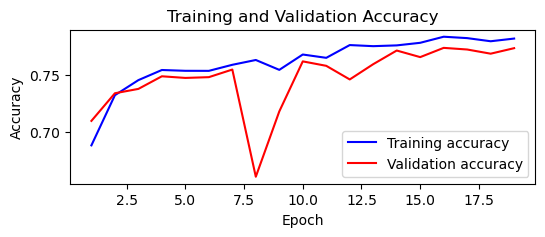

In [49]:
plt.figure(figsize=(6, 2))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [50]:
model.save('simple_unet.h5')

In [51]:
model = load_model('simple_unet.h5')

In [8]:
cap = cv2.VideoCapture(0)  # '0' is typically the default value for the webcam

In [52]:
def predict_segmentation(image_path, model_path):

    # Load and preprocess the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image_resized = cv2.resize(image, (256, 256)) / 255.0
    image_expanded = np.expand_dims(image_resized, axis=0)  # Add batch dimension

    # Predict the mask
    predicted_mask = model.predict(image_expanded)[0]  # Get the first (and only) prediction
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Convert to binary mask

    # Resize mask back to original size and overlay
    mask_resized = cv2.resize(predicted_mask, (image.shape[1], image.shape[0]))
    mask_colored = np.stack((mask_resized,)*3, axis=-1) * 255
    segmented_image = cv2.addWeighted(image, 1, mask_colored, 0.5, 0)

    return segmented_image

In [54]:
segmented_image = predict_segmentation('data\\testimg\\human1.jpg', 'simple_unet.h5')
cv2.imshow('Segmented Image', segmented_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 42ms/step
